In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
dataset = pd.read_csv('weatherAUS.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [4]:
dataset['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [5]:
dataset.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


В датасете есть категориальные признаки `Location`, `WindGusDir`, `WindDir9am`, `WindDir3pm`, `RainToday`, `RainTomorrow`. Значения в бинарных признаках `RainToday` и `RainTomorrow` заменим на 0 и 1, а для признаков с числом различных значений > 2 попробуем применить метод *OneHotEncoding*. Стоит заметить, что в целевой переменной есть пропуски, но так как они составляют всего (1 - 142193 / 145460) $\approx$ 2%, то можно просто их не рассматривать. 

In [6]:
dataset["RainTomorrow"].unique()

array(['No', 'Yes', nan], dtype=object)

In [7]:
index_to_del = np.where(dataset["RainTomorrow"].isna() == 1)[0]
dataset = dataset.drop(index_to_del)

Временной признак `Date` попробуем заменить следующим образом. Предположим, что климат в Австралии довольно устойчив, тогда переквалифицируем дату в 4 сезона года и применим уже упомянутый *OneHotEncoding*. 

In [8]:
# Конвертируем дату
mapa = {
    1: 'summer',
    2: 'summer',
    3: 'autumn',
    4: 'autumn',
    5: 'autumn',
    6: 'winter',
    7: 'winter',
    8: 'winter',
    9: 'spring',
    10: 'spring',
    11: 'spring',
    12: 'summer'
}
dataset['Date'] = dataset['Date'].apply(lambda x: mapa[int(str(x).split('-')[1])])

/home/alexloner/anaconda3/envs/ml_atom/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


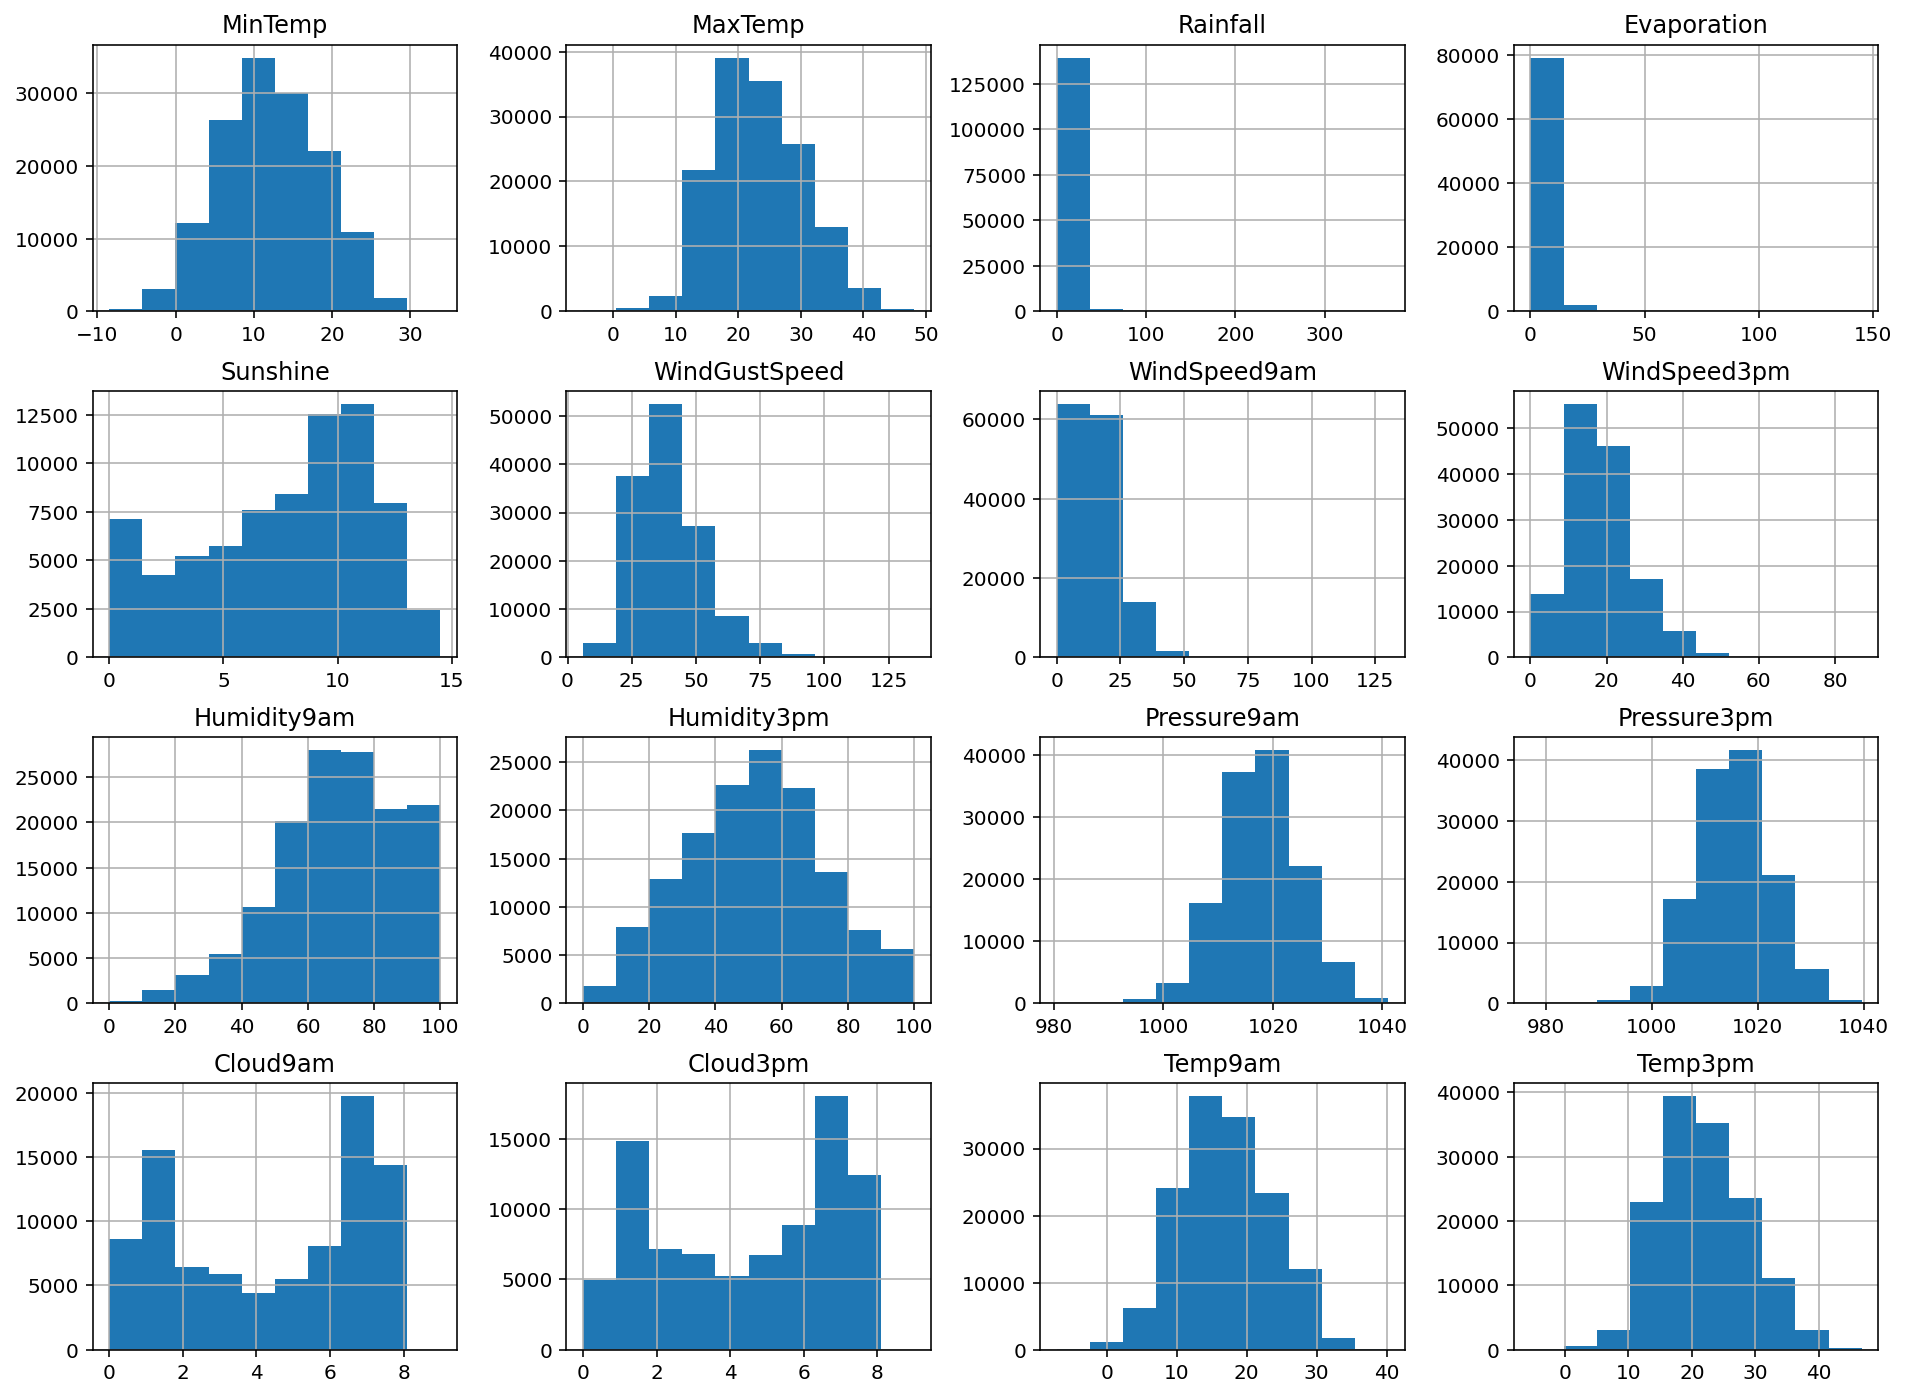

In [9]:
_ = dataset.hist(figsize=(16, 12))

Видно, что большинство признаков распределены приблизительно по нормальному закону, поэтому для них можно дополнить пропуски средним знaчением. 
Гораздо интереснее выглядят признаки `Cloud9am`, `Cloud3pm` для них пропущено почти половина значений и их распределение напоминает бимодальное, поэтому чтобы заполнить пропуски будем генерировать случаное значение из двух медиан.

Также около половины значений нет в признаках `Evaporation`, `Sunshine`. Их попробуем заполнить несколько иначе, будем дополнять их средним значением в зависимости от времени года +- шум*std, так как я считаю, что испарение и число солнечных дней могут быть связаны со временем года.


In [10]:
def fill_na_bimodal(x, values):
    return np.random.choice(values) if np.isnan(x) else x 

In [11]:
# Cloud3pm 
values = dataset.Cloud3pm.value_counts().index[:2]
dataset.Cloud3pm = dataset.Cloud3pm.apply(fill_na_bimodal, args=(values,))

# Cloud9am 
values = dataset.Cloud9am.value_counts().index[:2]
dataset.Cloud9am = dataset.Cloud9am.apply(fill_na_bimodal, args=(values,))

In [12]:
ds = dataset[['Date', 'Evaporation', 'Sunshine']].groupby(by='Date')
means = ds.mean()
stds = ds.std()

In [13]:
def fill_eva_sun(x, means, stds, season, feature):
        if np.isnan(x):
            return means.loc[season, feature] + (2*np.random.rand()-1) * stds.loc[season, feature]
        else:
            return x

In [14]:
for season in means.index:
    for feature in means.columns:
        dataset[feature] = dataset[feature].apply(fill_eva_sun, args=(means, stds, season, feature))

Остальные пропуски попробуем заполнить средним значением или наиболее частным для категориальных признаков

In [15]:
for feature in dataset.columns:
    if dataset[feature].isna().any():
        # Check feature type 
        if dataset[feature].dtype == 'float64':
            dataset[feature].fillna(value=dataset[feature].mean(), inplace=True)
        elif dataset[feature].dtype == 'O':
            dataset[feature].fillna(value=dataset[feature].value_counts().index[0], inplace=True)

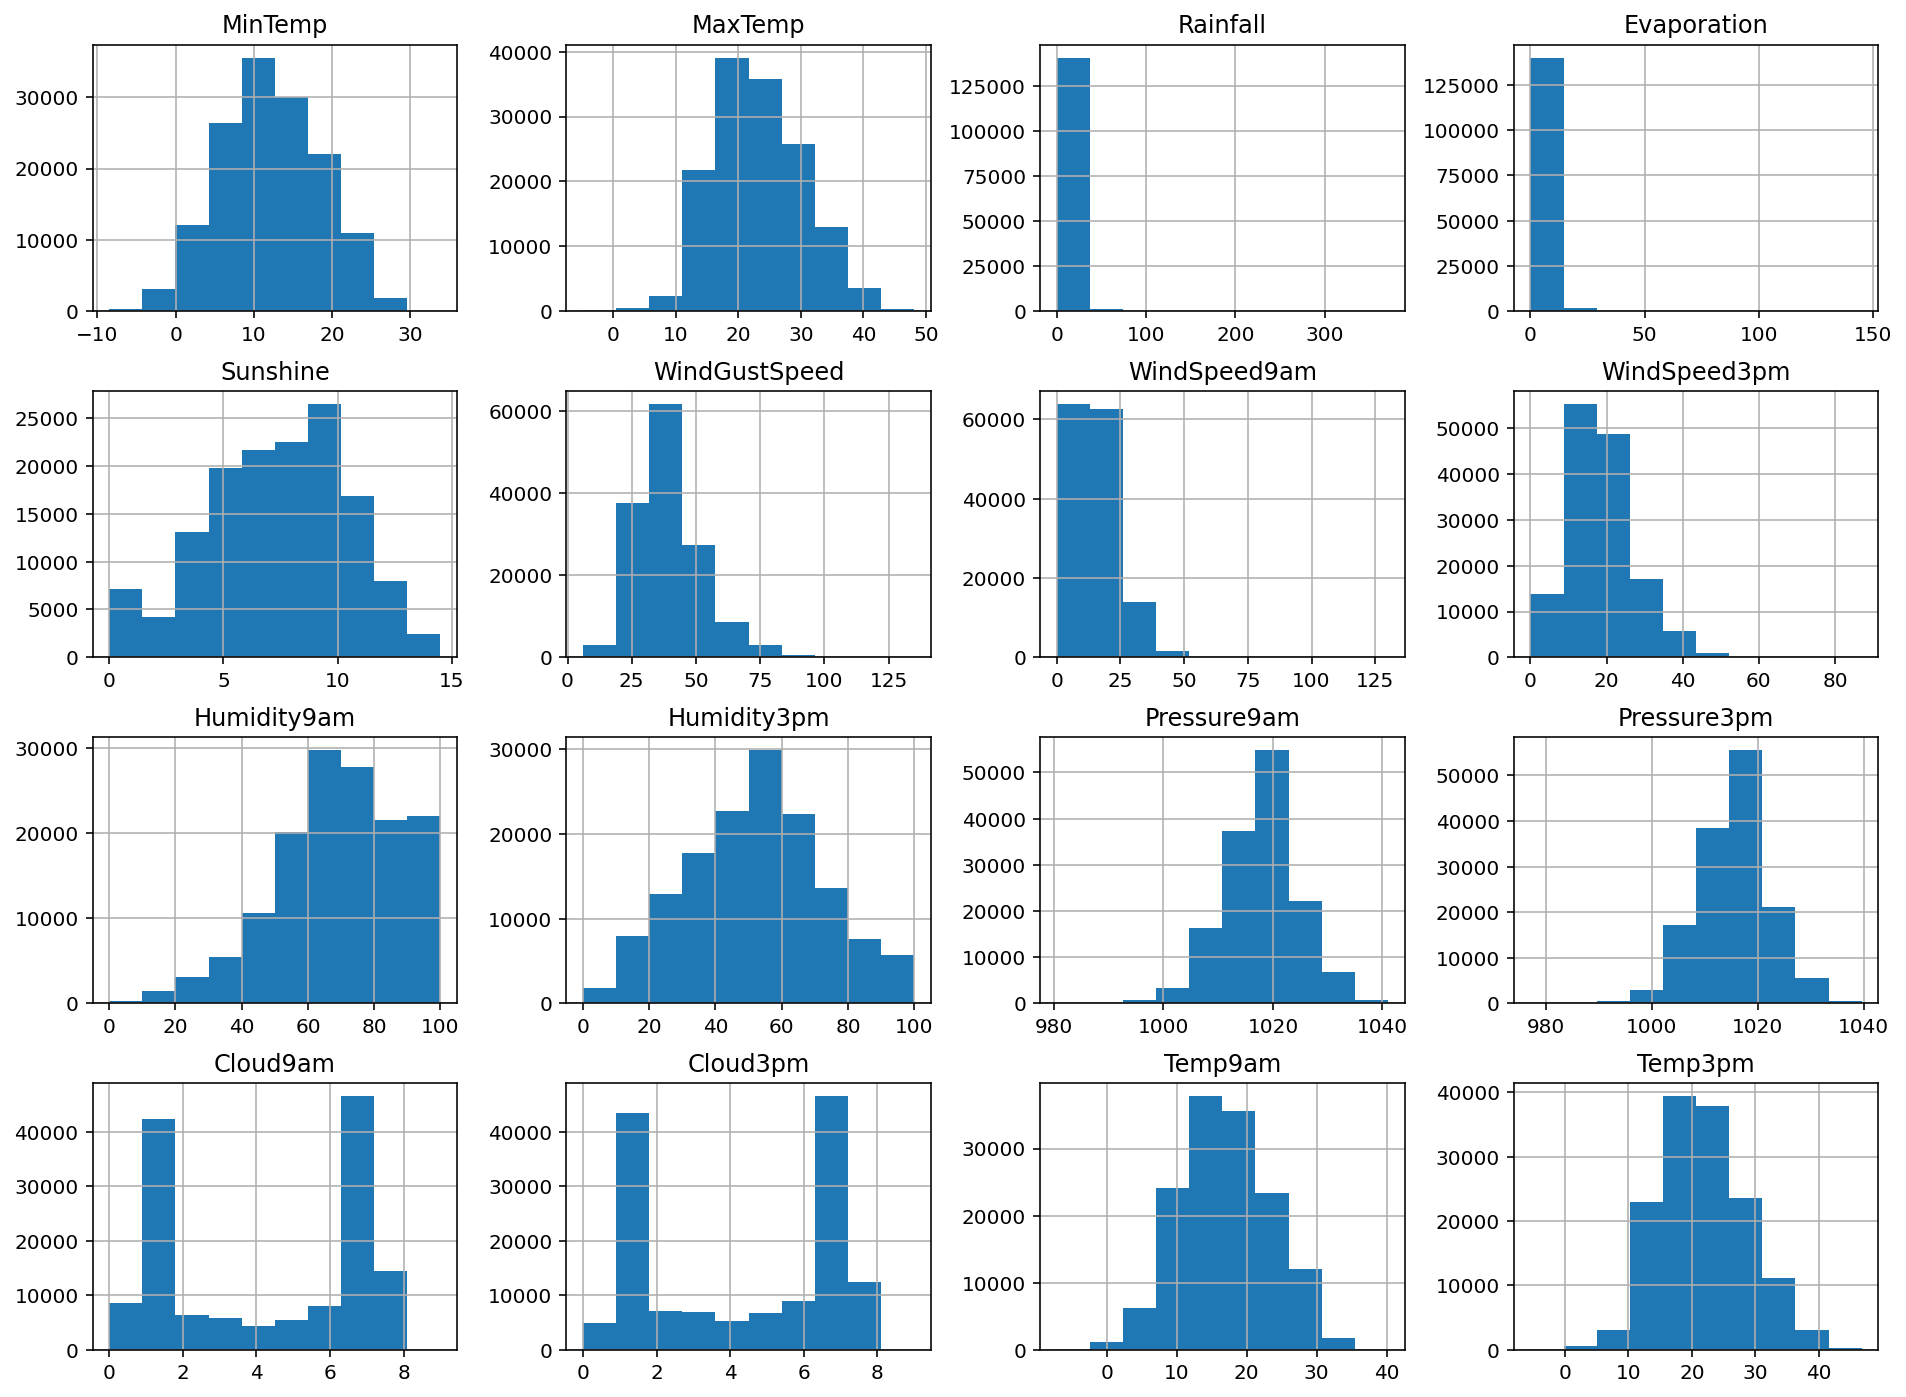

In [16]:
_ = dataset.hist(figsize=(16, 12))

In [17]:
dataset.RainToday = dataset.RainToday.apply(lambda x: 0 if x == 'No' else 1)
dataset.RainTomorrow = dataset.RainTomorrow.apply(lambda x: 0 if x == 'No' else 1)

In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        142193 non-null  float64
 3   MaxTemp        142193 non-null  float64
 4   Rainfall       142193 non-null  float64
 5   Evaporation    142193 non-null  float64
 6   Sunshine       142193 non-null  float64
 7   WindGustDir    142193 non-null  object 
 8   WindGustSpeed  142193 non-null  float64
 9   WindDir9am     142193 non-null  object 
 10  WindDir3pm     142193 non-null  object 
 11  WindSpeed9am   142193 non-null  float64
 12  WindSpeed3pm   142193 non-null  float64
 13  Humidity9am    142193 non-null  float64
 14  Humidity3pm    142193 non-null  float64
 15  Pressure9am    142193 non-null  float64
 16  Pressure3pm    142193 non-null  float64
 17  Cloud9am       142193 non-nul


Отделяем признаки от целевой переменной

In [19]:
target = dataset["RainTomorrow"].values

In [20]:
dataset.drop(columns="RainTomorrow", inplace=True)

Теперь нужно применить метод OneHotEncoder, чтобы с категориальными признаками можно было бы работать, для этого можно использовать функцию `pandas.get_dummies` куда нужно передать имена стобцов с категориальными признаками 


In [21]:
new_ds = pd.get_dummies(dataset, columns=['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], prefix='', prefix_sep='')
features = new_ds.values

In [22]:
del new_ds

Делим данные на тренировочные и тестовые 

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
random_state = 4
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, shuffle=False, random_state=random_state)

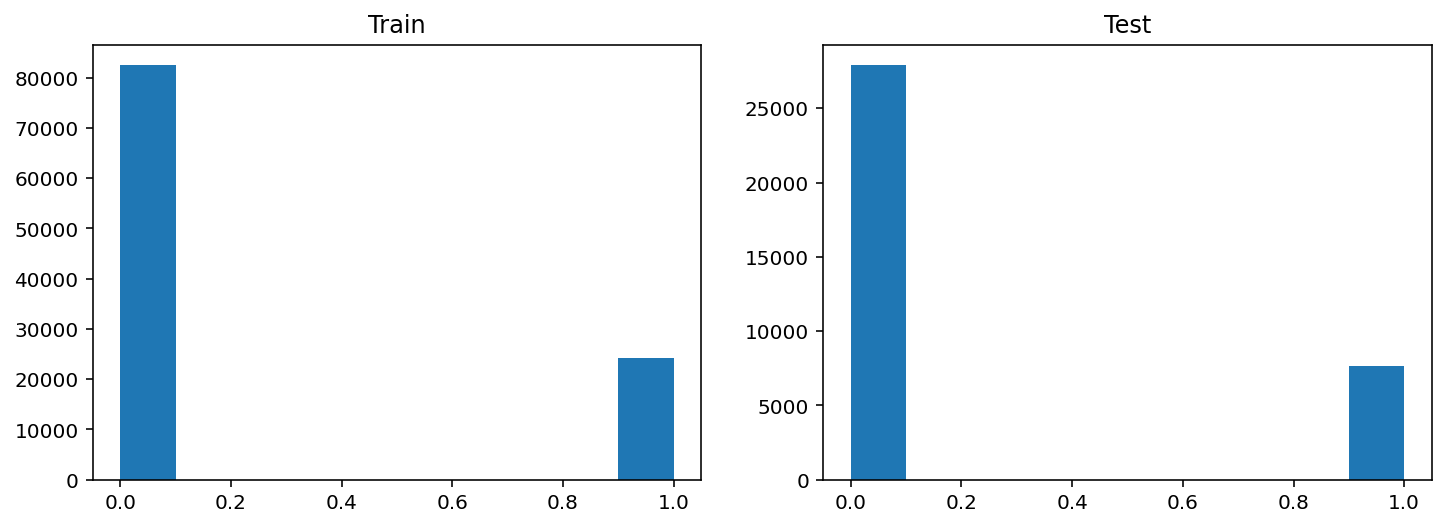

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title('Train')
ax[0].hist(y_train)
ax[1].set_title('Test')
_ = ax[1].hist(y_test)


Классы сильно несбалансированы, оценивать качество будем на метрике `recall_score` и `precision_score`

In [26]:
from sklearn.metrics import recall_score, precision_score

In [27]:
metric_evaluation = [precision_score, recall_score]

Отмасштабируем признаки

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
scaler = MinMaxScaler()
scaler.fit(x_train, y_train)
scaled_train_data = scaler.transform(x_train)
scaled_test_data = scaler.transform(x_test)

#### Байесовские классификаторы 

In [30]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [31]:
%%time
bayes_results = []
for cl in [GaussianNB, BernoulliNB, MultinomialNB]: 
    model = cl()
    model.fit(scaled_train_data, y_train)
    model_result = model.predict(scaled_test_data)
    bayes_results.append([precision_score(y_test, model_result), recall_score(y_test, model_result)])

CPU times: user 829 ms, sys: 985 ms, total: 1.81 s
Wall time: 572 ms


In [32]:
bayes_results

[[0.45591590612777055, 0.7297508803965045],
 [0.4294588997929234, 0.6221468631798618],
 [0.43850677576067504, 0.6710577800965175]]

#### Логистическая регрессия

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [34]:
params = {
    "penalty": ['l2', 'l1'],
    "C": [0.001, 0.005, 0.01, 0.05, 0.1]
}

In [35]:
%%time
best_estimators = []
cv_results = []
log_results = []

for (scoring, metric) in zip(['precision', 'recall'], [precision_score, recall_score]):
    model = GridSearchCV(LogisticRegression(solver='liblinear', random_state=random_state), param_grid=params, cv=3, scoring=scoring, n_jobs=-1)
    model.fit(scaled_train_data, y_train)
    best_estimators.append(model.best_estimator_)
    cv_results.append(model.cv_results_['mean_test_score'])
    predict = model.predict(scaled_test_data)
    log_results.append(metric(y_test, predict))

CPU times: user 22.1 s, sys: 1.09 s, total: 23.1 s
Wall time: 1min 54s


In [36]:
best_estimators

[LogisticRegression(C=0.001, penalty='l1', random_state=4, solver='liblinear'),
 LogisticRegression(C=0.1, penalty='l1', random_state=4, solver='liblinear')]

In [37]:
cv_results

[array([0.77741739, 0.79768237, 0.71790359, 0.7324756 , 0.69369032,
        0.70713768, 0.64471186, 0.62457257, 0.62572612, 0.61119692]),
 array([0.19285419, 0.13519207, 0.3764147 , 0.40693928, 0.42825279,
        0.4512185 , 0.50008261, 0.50875671, 0.51759603, 0.51842214])]

In [38]:
log_results

[0.8076766026949775, 0.4918481805138907]

#### Ближайшие соседи

In [39]:
from sklearn.neighbors import KNeighborsClassifier

In [40]:
import time

In [41]:
%%time

knn_results = []
for p in [1, 2]:
    for nn in [10, 15, 20, 25]:
        t1 = time.time()
        model = KNeighborsClassifier(n_neighbors=nn, p=p, weights='distance', n_jobs=-1)
        model.fit(x_train, y_train)
        tmp_res = model.predict(x_test)
        knn_results.append([precision_score(y_test, tmp_res), recall_score(y_test, tmp_res)])
        t2 = time.time() - t1 
        print(f"Distance {p} nn {nn} :: time {t2} :: precision {knn_results[-1][0]:.4f} :: recall {knn_results[-1][1]:.4f}")

Distance 1 nn 10 :: time 190.48953127861023 :: precision 0.7272 :: recall 0.4442
Distance 1 nn 15 :: time 193.38204956054688 :: precision 0.7515 :: recall 0.4289
Distance 1 nn 20 :: time 191.74951171875 :: precision 0.7639 :: recall 0.4242
Distance 1 nn 25 :: time 189.1037302017212 :: precision 0.7735 :: recall 0.4179
Distance 2 nn 10 :: time 123.34238815307617 :: precision 0.7148 :: recall 0.4433
Distance 2 nn 15 :: time 120.26872730255127 :: precision 0.7406 :: recall 0.4302
Distance 2 nn 20 :: time 119.6634247303009 :: precision 0.7553 :: recall 0.4283
Distance 2 nn 25 :: time 120.78340005874634 :: precision 0.7644 :: recall 0.4231
CPU times: user 1h 24min 1s, sys: 20min 2s, total: 1h 44min 4s
Wall time: 20min 48s


In [42]:
knn_results

[[0.7271562766865927, 0.44424155471501237],
 [0.7515428571428572, 0.428850919525238],
 [0.7639182522903453, 0.42415547150123906],
 [0.7735393529695799, 0.41789487413590715],
 [0.714826498422713, 0.4433285509325681],
 [0.7406242982259151, 0.43015521064301554],
 [0.7552897884084636, 0.42832920307812705],
 [0.764373232799246, 0.42311203860701707]]

#### Результаты 

Модели оценивались по двум метрикам `precision` и `recall`, они были выбраны, так как являются устойчивыми к дисбалансу классов, который в данном наборе данных довольно большой.

Байесовские модели показали лучшие результаты по метрике `recall`, что говорит о том, что данные модели лучше способны распознавать дождливый будет день или нет. Самый высокий результат показала модель `GaussianNB` $\approx$ 73%, что может быть связано с тем, что распределение большинства признаков напоминает нормальное.

Касательно метрики `precision` лучшей моделью оказалась `LogissticRegression()` с Лассо регурелизатором и обратным значением коэффициента регурелизации С = 0.001  и приближенным результатом в 80%. Модель ближайших соседей дала приблизительно такой же результат 77%  для числа соседей = 25 и манхэттенской метрики.

Таким образом, если мы хотим уменьшать случаи, когда алгоритм говорит, что будет дождя не будет, а он идет, то нужно использовать `GaussianNB` и метрику `recall`. Если же нужно уменьшать ложные срабатывания, то необходимо выбрать `LogisticRegression` и метрику `precision`.